In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [3]:
EPOCHS = 30
data_dir = "/content/drive/MyDrive/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [5]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True),
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True),
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [7]:
len(dataloaders[TRAIN])

1307

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

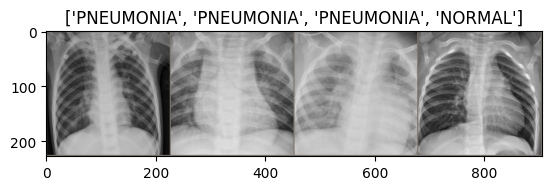

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [11]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_pre = models.vgg16()
##model_pre.load_state_dict(torch.load("../input/pytorch-pretrained-models/vgg16-397923af.pth"))

In [15]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
model_pre = train_model(model_pre, criterion, optimizer,exp_lr_scheduler,num_epochs=EPOCHS)

Epoch: 1/30
train Loss: 0.1665 Acc: 0.9353
val Loss: 1.8176 Acc: 0.6250
Epoch: 2/30
train Loss: 0.1435 Acc: 0.9462
val Loss: 0.6214 Acc: 0.8125
Epoch: 3/30
train Loss: 0.1360 Acc: 0.9480
val Loss: 0.8394 Acc: 0.6875
Epoch: 4/30
train Loss: 0.1254 Acc: 0.9524
val Loss: 0.7598 Acc: 0.8125
Epoch: 5/30
train Loss: 0.1196 Acc: 0.9533
val Loss: 0.6582 Acc: 0.6875
Epoch: 6/30
train Loss: 0.1120 Acc: 0.9579
val Loss: 0.7627 Acc: 0.7500
Epoch: 7/30
train Loss: 0.1110 Acc: 0.9568
val Loss: 0.9940 Acc: 0.6875
Epoch: 8/30
train Loss: 0.1083 Acc: 0.9606
val Loss: 0.9431 Acc: 0.5625
Epoch: 9/30
train Loss: 0.0795 Acc: 0.9698
val Loss: 1.0162 Acc: 0.6875
Epoch: 10/30
train Loss: 0.0736 Acc: 0.9734
val Loss: 1.0075 Acc: 0.8125
Epoch: 11/30
train Loss: 0.0716 Acc: 0.9730
val Loss: 1.0698 Acc: 0.6875
Epoch: 12/30
train Loss: 0.0686 Acc: 0.9755
val Loss: 1.0386 Acc: 0.8125
Epoch: 13/30
train Loss: 0.0692 Acc: 0.9738
val Loss: 1.1318 Acc: 0.6875
Epoch: 14/30
train Loss: 0.0660 Acc: 0.9753
val Loss: 1.0964

In [23]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [24]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [25]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 505.0, Total Test Images: 624.0
Test Accuracy:  0.8092948717948718


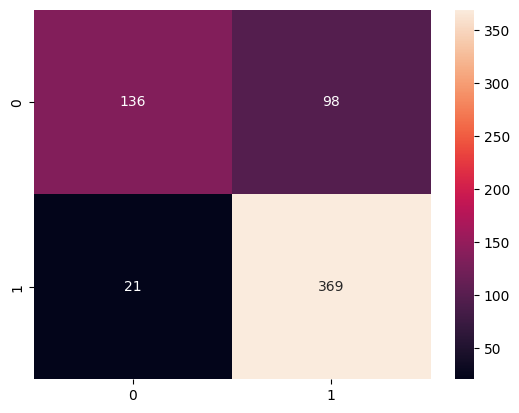

In [26]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")